<h1>Imports and Dataset</h1>

In [1]:
#!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [3]:
#gets the GPUs on the machine you are using
gpus = tf.config.experimental.list_physical_devices('GPU')

#looping through all the GPUs and setting memory gowth (so tensforlow wil allocate the memory it needs and not over use VRAM)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
#Fashion Dataset 
data = tfds.load('fashion_mnist', split='train')

<h1>Data Vizualisation and Data Pipeline</h1>

In [5]:
#Setup Connection to data iterator
data_iterator = data.as_numpy_iterator()

In [6]:
#Getting data out of iterator
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

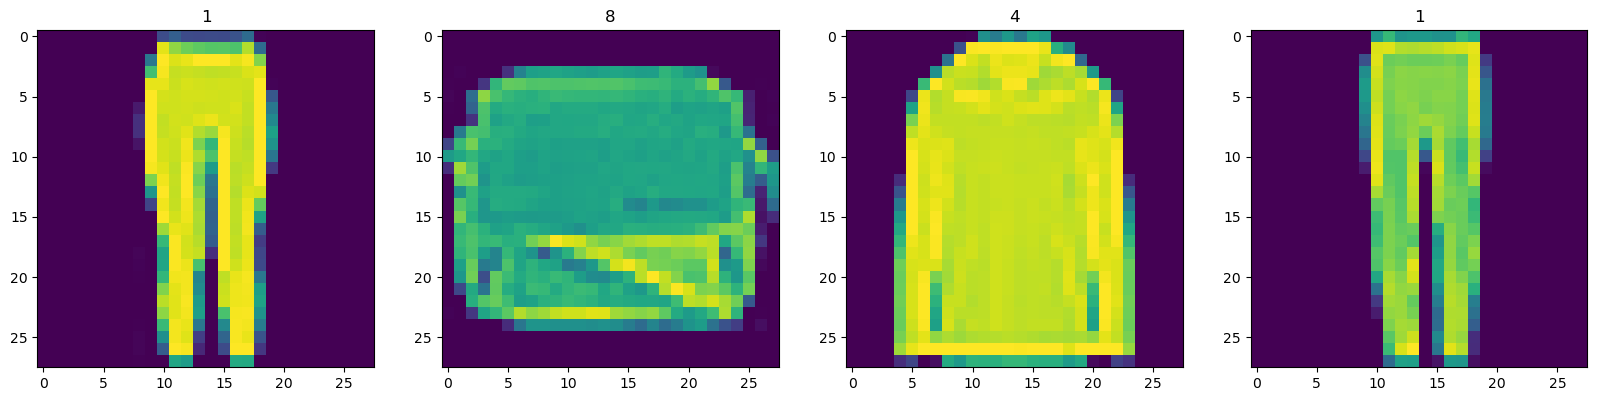

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
    batch = data_iterator.next()
    ax[i].imshow(np.squeeze(batch['image']))
    ax[i].title.set_text(batch['label'])

In [8]:
#Scaling and returning images
#Will Scale image between 0 and 1 to train model faster
def scale_image(img):
    image = img['image']
    return image/255

In [9]:
#Steps when creating a Tensorflow Pipeline
#1)map - map a function to dataset
#2)cache - Cache dataset for that batch
#3)shuffle - Shuffle dataset
#4)batch - set betch size e.g. batch(128) will be 128 images per sample
#5)prefetch - Reduced the likelihood of bottlenecking

In [10]:
data = data.map(scale_image)
data = data.cache()
data = data.shuffle(60000)
data = data.batch(128)
data= data.prefetch(64)

In [11]:
data.as_numpy_iterator().next().shape

(128, 28, 28, 1)

<h1>Model</h1>

<p>Building two models - Generator and Discriminator</p>
<p>Generator will generate the images</p>
<p>Discriminator will decide whether input image (from Generator) is real or fake</p>

In [12]:
def build_genetor():
    model = Sequential()
    
    #Takes in random values and reshapes it to 7x7x128
    #Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))
    
    #Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    #Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    #Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
        
    #Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    #Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [13]:
generator = build_genetor()

/Users/max/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
img = generator.predict(np.random.randn(4,128,1))
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


array([[[[0.49341974],
         [0.4995324 ],
         [0.5024786 ],
         ...,
         [0.50013936],
         [0.49774235],
         [0.5006769 ]],

        [[0.490255  ],
         [0.49820393],
         [0.4999719 ],
         ...,
         [0.49530065],
         [0.49948028],
         [0.50112337]],

        [[0.49554455],
         [0.49970254],
         [0.5089585 ],
         ...,
         [0.49610913],
         [0.49783528],
         [0.5028237 ]],

        ...,

        [[0.49294052],
         [0.49663222],
         [0.4920602 ],
         ...,
         [0.49302125],
         [0.49371055],
         [0.49929905]],

        [[0.49369612],
         [0.4933584 ],
         [0.49259493],
         ...,
         [0.49454734],
         [0.49634078],
         [0.500948  ]],

        [[0.4959434 ],
         [0.4951425 ],
         [0.49843517],
         ...,
         [0.4983152 ],
         [0.49897835],
         [0.49985456]]],


       [[[0.4968903 ],
         [0.4964776 ],
         [0.49

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


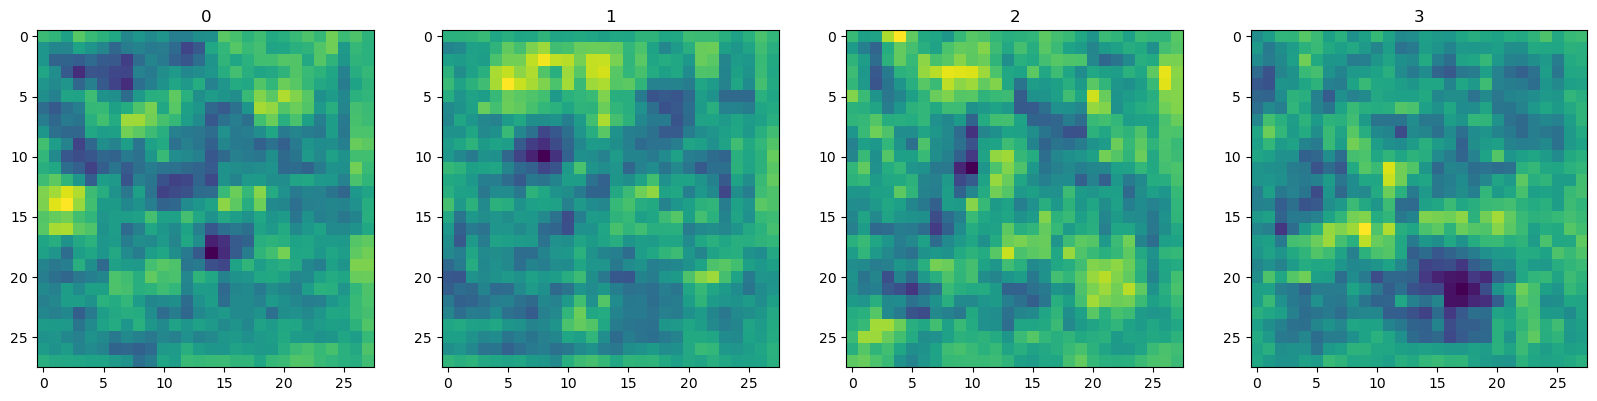

In [16]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, img in enumerate(img):
    batch = data_iterator.next()
    ax[i].imshow(np.squeeze(img))
    ax[i].title.set_text(i)

In [17]:
def build_discriminator():
    model = Sequential()
    
    #First Convolutional Block
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Second Convolutional Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Third Convolutional Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Fourth Convolutional Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    #Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [18]:
discriminator = build_discriminator()

/Users/max/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [19]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#if img = generator.predict(np.random.randn(4,128,1)) -> img.shape = (4, 28, 28, 1)
#then discriminator.predict(img)

#However after plotting the images the shape is (28, 28, 1)), so we do:
#discriminator.predict(np.expand_dims(img, 0))

#Reset img

img = generator.predict(np.random.randn(4,128,1))
discriminator.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([[0.49668306],
       [0.49636263],
       [0.49632823],
       [0.4963626 ]], dtype=float32)

<h1>Training Loop</h1>

<p>Typically when Training a Deep Neural network in tf you can create a model, then model.compile to add a loss function and optimizer and then do model.fit to fit the model to the data. However you can't do that in GANs because you have a generator and a discriminator that need to be trained side by side. So we are defining our own training loop</p>

<p>To train the discriminator:</p>
<ol>
    <li>Pass the real and fake images to the discriminator</li>
    <li>Create labels for real and fake images</li>
    <li>Add some noise to the outputs</li>
    <li>Calculate loss - Binary Cross Entropy</li>
    <li>Apply backpropagation - learn</li>
</ol>

<p>To train the Generator:</p>
<ol>
    <li>Generate some new images</li>
    <li>Create the predicted labels</li>
    <li>Calculate loss</li>
    <li>Apply backpropagation - learn</li>
</ol>

In [21]:
gen_opt = Adam(learning_rate=0.0001)
gen_loss = BinaryCrossentropy()

#discriminator learning rate is set lower so it doesn't learn too fast - otherwise it would be bad for the generator
dis_opt = Adam(learning_rate=0.00001)
dis_loss = BinaryCrossentropy()

In [22]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        #Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        
        #Create attributes for gen and dis
        self.generator = generator
        self.discriminator = discriminator
        
    def compile_model(self, gen_opt, dis_opt, gen_loss, dis_loss, *args, **kwargs):
        #Compile with base class
        super().compile(*args, **kwargs)
                        
        #Create attributes for losses and optimizers
        self.gen_opt = gen_opt
        self.gen_loss = gen_loss
        
        self.dis_opt = dis_opt
        self.dis_loss = dis_loss
        
    def train_step(self, batch):
        #Get data
        real_imgs = batch
        fake_imgs = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        #Train the disriminator
        with tf.GradientTape() as d_tape:
            #Pass values to discriminator
            yhat_real = self.discriminator(real_imgs, training=True)
            yhat_fake = self.discriminator(fake_imgs, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            #Labels
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            #Noise
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            #Loss
            total_dis_loss= self.dis_loss(y_realfake, yhat_realfake)
            
        #Backpropagatioon
        dis_grad = d_tape.gradient(total_dis_loss, self.discriminator.trainable_variables)
        self.dis_opt.apply_gradients(zip(dis_grad, self.discriminator.trainable_variables))
        
        #Train the generator
        with tf.GradientTape() as g_tape:
            #Gen Images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)
            
            #Labels - Training set to false so ddiscriminator isn't learning while we are training the Generator
            predicted_labels = self.discriminator(gen_images, training=False)
            
            #Loss - real images are zeros, so we calculate how many of our predicted labels have been predicted 0
            #since thte generated images are actually real, we reward our generator for tricking the discriminator (discriminator predicts gen image is real)
            total_gen_loss = self.gen_loss(tf.zeros_like(predicted_labels), predicted_labels)
            
        #Backpropagation
        gen_grad = g_tape.gradient(total_gen_loss, self.generator.trainable_variables)
        self.gen_opt.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        
        return {'dis_loss': total_dis_loss, 'gen_loss': total_gen_loss}

In [23]:
#Instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [24]:
#Compile
fashgan.compile_model(gen_opt, dis_opt, gen_loss, dis_loss)

In [25]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy() 
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('Fashion-GAN-images', f'generated_img_{epoch}_{i}.png')) 

In [26]:
#Recommend 2000 epochs
hist = fashgan.fit(data, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3523s 8s/step - dis_loss: 0.5668 - gen_loss: 0.8557 - loss: 0.0000e+00
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 27663s 59s/step - dis_loss: 0.6956 - gen_loss: 0.6973 - loss: 0.0000e+00
Epoch 3/20
458/469 ━━━━━━━━━━━━━━━━━━━━ 15:06 82s/step - dis_loss: 0.6870 - gen_loss: 0.6828

KeyboardInterrupt: 